In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import numpy as np
import pickle

In [241]:
test_index = '101'
slide_path = '../images/tumor_' + test_index + '.tif'
tumor_mask_path = '../images/tumor_' + test_index + '_mask.tif'
slide, tumor_mask = open_slide(slide_path), open_slide(tumor_mask_path)

In [242]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [243]:
def get_center(slide):
  coor = []
  x_list = list(range((299//2)*8, (slide.level_dimensions[6][0] - 299//2)*8 , 128))
  y_list = list(range((299//2)*8, (slide.level_dimensions[6][1] - 299//2)*8 , 128))
  for x in x_list:
    for y in y_list:
      coor.append((x,y))
  return coor
#coor[i][0],coor[i][1]:x,y

In [244]:
#extract patches for exact coors
def extractpatches(image,x,y,level_num):
  scale = 2**(level_num - 3)
  scale2 = 2**level_num
  region = read_slide(image, (x//scale - 299//2)*scale2, (y//scale - 299//2)*scale2, level = level_num, width=299, height=299)
  return region

In [245]:
def preparetestdata(image,coor_list,level_list):
  res = []
  for coor in coor_list:
      patch = []
      for level in level_list:
        area = extractpatches(image,coor[0],coor[1],level)
        patch.append(area)
      res.append(patch)
  res = np.array(res)
  return res #res: np (#, 4,299,299,3) 

In [246]:
#[3,4,5,6]
coor_list = get_center(slide)
res = preparetestdata(slide,coor_list,[3,4,5,6])

# Load Model

In [247]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import regularizers

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.nn import softmax, sigmoid

import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16,VGG19,inception_v3, densenet, mobilenet,mobilenet_v2
import os,sys

In [248]:
conv_base = InceptionV3(include_top=False, weights='imagenet')
conv_base.trainable = False

In [249]:
inputs = [tf.keras.Input(shape=(299,299,3)),tf.keras.Input(shape=(299,299,3)), \
          tf.keras.Input(shape=(299,299,3)),tf.keras.Input(shape=(299,299,3))]

layer1_conv = conv_base(inputs[0])
layer1_flatten = Flatten()(layer1_conv)
layer1_dense1 = Dense(64,activation = 'relu')(layer1_flatten)
#layer1_dense2 = Dense(32,activation = 'relu')(layer1_dense1)
layer1 = Dropout(0.4)(layer1_dense1)

layer2_conv = conv_base(inputs[1])
layer2_flatten = Flatten()(layer2_conv)
layer2_dense1 = Dense(64,activation = 'relu')(layer2_flatten)
#layer2_dense2 = Dense(32,activation = 'relu')(layer2_dense1)
layer2 = Dropout(0.4)(layer2_dense1)

layer3_conv = conv_base(inputs[2])
layer3_flatten = Flatten()(layer3_conv)
layer3_dense1 = Dense(64,activation = 'relu')(layer3_flatten)
#layer3_dense2 = Dense(32,activation = 'relu')(layer3_dense1)
layer3 = Dropout(0.4)(layer3_dense1)

layer4_conv = conv_base(inputs[3])
layer4_flatten = Flatten()(layer4_conv)
layer4_dense1 = Dense(64,activation = 'relu')(layer4_flatten)
#layer4_dense2 = Dense(32,activation = 'relu')(layer4_dense1)
layer4 = Dropout(0.4)(layer4_dense1)

merged_input = tf.concat([layer1,layer2,layer3,layer4],axis = 1)
output = tf.keras.layers.Dense(1,'sigmoid')(merged_input)
model = Model(inputs=inputs, outputs=output)

In [250]:
# optimizer = tf.keras.optimizers.RMSprop(lr=0.05, rho=0.9, epsilon=1.0, decay=0.9)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer, loss='binary_crossentropy',metrics = ['accuracy'])

In [251]:
model.load_weights("../models/model_except110.h5")

In [252]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 299, 299, 3) 0                                            
____________________________________________________________________________________________

# Predict

In [253]:
final_coor = []
cnt = 0
for i,coor in enumerate(coor_list):
    data =[res[[i],0,:,:,:]/255,res[[i],1,:,:,:]/255, res[[i],2,:,:,:]/255,res[[i],3,:,:,:]/255]
    predict_res = model.predict(x = data,batch_size=1, verbose=0, steps=None, callbacks=None)
    final_res = 1 if predict_res[0] > 0.96 else 0
    if final_res == 1:
        final_coor.append(coor)
    if cnt%100 == 0:
        print(cnt, "-- current tumor:" , len(final_coor))
    cnt+=1

0 -- current tumor: 0
100 -- current tumor: 0
200 -- current tumor: 0
300 -- current tumor: 0
400 -- current tumor: 0
500 -- current tumor: 1
600 -- current tumor: 5
700 -- current tumor: 12
800 -- current tumor: 22
900 -- current tumor: 31
1000 -- current tumor: 43
1100 -- current tumor: 55
1200 -- current tumor: 61
1300 -- current tumor: 69
1400 -- current tumor: 72
1500 -- current tumor: 75
1600 -- current tumor: 94
1700 -- current tumor: 108
1800 -- current tumor: 122
1900 -- current tumor: 126
2000 -- current tumor: 130
2100 -- current tumor: 136
2200 -- current tumor: 140
2300 -- current tumor: 141
2400 -- current tumor: 142
2500 -- current tumor: 142
2600 -- current tumor: 142
2700 -- current tumor: 142
2800 -- current tumor: 142
2900 -- current tumor: 142
3000 -- current tumor: 142
3100 -- current tumor: 142
3200 -- current tumor: 142
3300 -- current tumor: 142
3400 -- current tumor: 142
3500 -- current tumor: 142
3600 -- current tumor: 142
3700 -- current tumor: 142
3800 -- cu

In [254]:
print(len(final_coor))

296


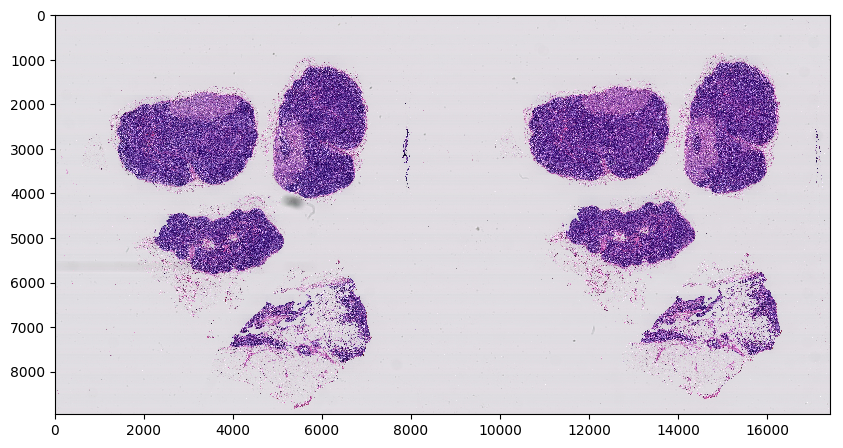

In [255]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=3, 
                         width=slide.level_dimensions[3][0], 
                         height=slide.level_dimensions[3][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

# Tumor

In [256]:
#tumor = np.where(mask_image == 1)
#coor = list(zip(tumor[0], tumor[1]))
coor = final_coor
image_size = (slide_image.shape[0], slide_image.shape[1])
predict_mask  = np.zeros(image_size,dtype=np.uint8)

In [257]:
def plotpredict(size, image, coor):
    # @ functuin: plot predicted tumor
    # @ param: size: patche's size | image: blank image | coor: tumors' predicted coordinates
    # @ return: predicted tumor mask
    for (x, y) in coor:
        left, right = y - size/2, y + size/2
        top, bottem = x - size/2, x + size/2
        left, right,top, bottem = int(left), int(right), int(top), int(bottem)
        image[left:right , top:bottem] = 1
    return image

## Predict tumor

In [258]:
predict_mask = plotpredict(128, predict_mask , coor)

# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=3, 
                        width=slide.level_dimensions[3][0], 
                        height=slide.level_dimensions[3][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

In [259]:
# Morphological Transformations
import cv2
kernel = np.ones((200,200),np.uint8)
closing = cv2.morphologyEx(predict_mask, cv2.MORPH_OPEN, kernel)
dilation = cv2.dilate(closing,kernel,iterations = 1)
dilation = closing

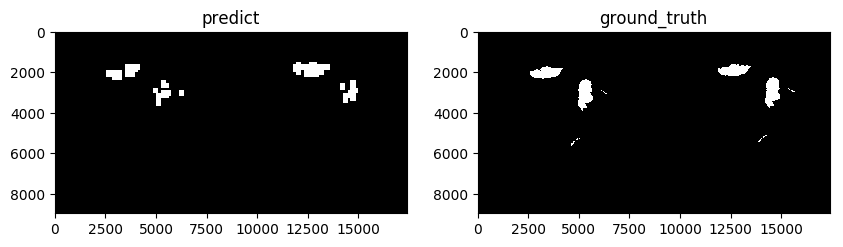

In [260]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=100)
for ax, img, interp in zip(ax, [dilation, mask_image],  ['predict', 'ground_truth']):
    ax.imshow(img,cmap ='gray')
    ax.set_title(interp)
    ax.grid(False)

plt.show()
path = '../results/' + str(test_index) + '/' + 'tumor_mask.png'
fig.savefig(path, dpi=fig.dpi, bbox_inches='tight')

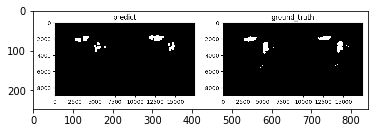

In [261]:
img=plt.imread(path)
plt.imshow(img, cmap = 'gray')

## Plot on Slide

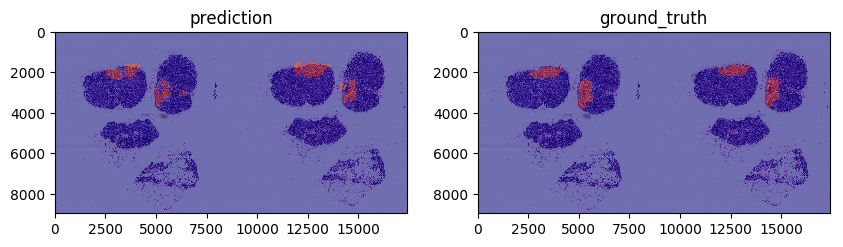

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10), dpi=100)

axes[0].imshow(slide_image)
axes[0].imshow(dilation, cmap='jet', alpha=0.5) # Red regions contains cancer.
axes[0].set_title('prediction')

axes[1].imshow(slide_image)
axes[1].imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.
axes[1].set_title('ground_truth')
plt.show()

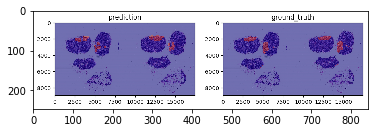

In [263]:
path = '../results/' + str(test_index) + '/' + 'tumor.png'
fig.savefig(path, dpi=fig.dpi, bbox_inches='tight')
img=plt.imread(path)
plt.imshow(img)

# IOU and Confusion Matrix

In [264]:
from pandas_ml import ConfusionMatrix

In [265]:
#confusion_matrix = ConfusionMatrix(y_true, y_pred)
confusion_matrix = ConfusionMatrix(mask_image.reshape(-1), dilation.reshape(-1))

In [266]:
print("Binary confusion matrix:\n%s" % confusion_matrix)

Binary confusion matrix:
Predicted      False     True    __all__
Actual                                  
False      152142818   831831  152974649
True          900126  2100905    3001031
__all__    153042944  2932736  155975680


In [267]:
# import seaborn as sns
# cm = np.array([[confusion_matrix.TP, confusion_matrix.FN], [confusion_matrix.FP, confusion_matrix.TN]])
# cm = cm/cm.sum

In [268]:
# fig = sns.heatmap(cm, center=0, annot=True, cmap="YlGnBu",  xticklabels=['Pred_True', 'Pred_False'], yticklabels=['Actual_True', 'Actual_False'])
# fig.figure.savefig('cm.png', bbox_inches='tight')
# # img=plt.imread('cm.png')
# # plt.imshow(img)

In [269]:
IOU = confusion_matrix.TP / (confusion_matrix.TP + confusion_matrix.FN + confusion_matrix.FP)
RECALL = confusion_matrix.TP / (confusion_matrix.TP + confusion_matrix.FN)
ACCURACY = (confusion_matrix.TP + confusion_matrix.TN) / (confusion_matrix.TN + confusion_matrix.TP + confusion_matrix.FN + confusion_matrix.FP)

In [270]:
print("IOU:" + str(IOU), '\nRecall' + str(RECALL), "\nAccuracy: " + str(ACCURACY))

IOU:0.5481295700184353 
Recall0.7000610790091805 
Accuracy: 0.9888959804502856


In [271]:
path = '../results/' + str(test_index) + '/' + 'pixel_metric.txt'
file = open(path,"w")
file.write('IOU: ' + str(IOU)) 
file.write('\nRECALL: ' + str(RECALL))
file.write('\nACCURACY: ' + str(ACCURACY))
file.close()

In [272]:
import gc
gc.collect()

165291